<a href="https://colab.research.google.com/github/ajay47847/pcg_classification/blob/main/AllpsdStandSvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


    Record Name  PSD 25-75 Hz Bin 1  PSD 25-75 Hz Bin 2  PSD 25-75 Hz Bin 3  PSD 25-75 Hz Bin 4  PSD 25-75 Hz Bin 5  PSD 25-75 Hz Bin 6  PSD 75-125 Hz Bin 1  PSD 75-125 Hz Bin 2  PSD 75-125 Hz Bin 3  PSD 75-125 Hz Bin 4  PSD 75-125 Hz Bin 5  PSD 75-125 Hz Bin 6  PSD 125-175 Hz Bin 1  PSD 125-175 Hz Bin 2  PSD 125-175 Hz Bin 3  PSD 125-175 Hz Bin 4  PSD 125-175 Hz Bin 5  PSD 125-175 Hz Bin 6  PSD 125-175 Hz Bin 7  PSD 175-225 Hz Bin 1  PSD 175-225 Hz Bin 2  PSD 175-225 Hz Bin 3  PSD 175-225 Hz Bin 4  PSD 175-225 Hz Bin 5  PSD 175-225 Hz Bin 6  PSD 225-275 Hz Bin 1  PSD 225-275 Hz Bin 2  PSD 225-275 Hz Bin 3  PSD 225-275 Hz Bin 4  PSD 225-275 Hz Bin 5  PSD 225-275 Hz Bin 6  PSD 225-275 Hz Bin 7  PSD 275-325 Hz Bin 1  PSD 275-325 Hz Bin 2  PSD 275-325 Hz Bin 3  PSD 275-325 Hz Bin 4  PSD 275-325 Hz Bin 5  PSD 275-325 Hz Bin 6  PSD 325-375 Hz Bin 1  PSD 325-375 Hz Bin 2  PSD 325-375 Hz Bin 3  PSD 325-375 Hz Bin 4  PSD 325-375 Hz Bin 5  PSD 325-375 Hz Bin 6  PSD 375-425 Hz Bin 1  PSD 375-425

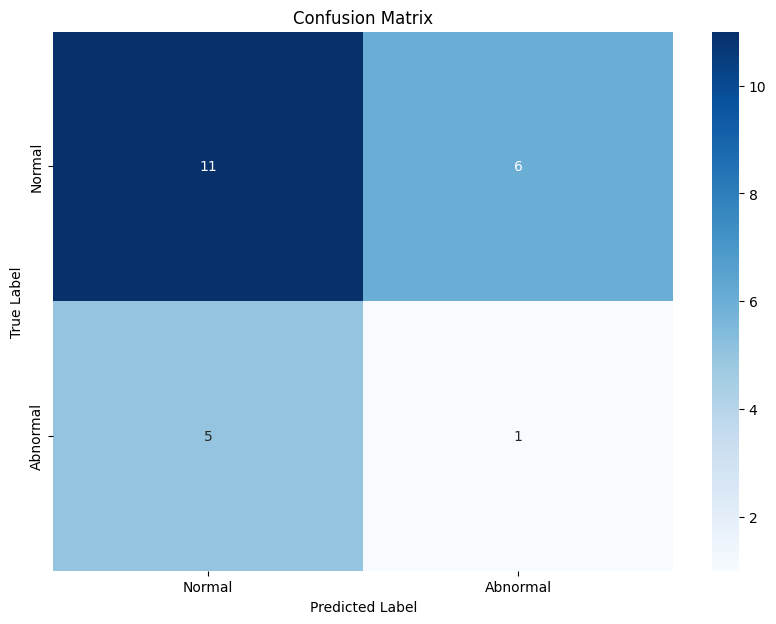

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Function to load audio files from a specified folder
def load_audio_files(file_list, folder_path):
    audio_data = []
    record_names = []
    min_length = float('inf')
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        record_names.append(file_name)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), record_names, sr

# Function to apply a bandpass filter
def apply_filter(data, sample_rate, filter_type, cutoff_freqs):
    nyquist = 0.5 * sample_rate
    normalized_cutoff = [freq / nyquist for freq in cutoff_freqs]
    b, a = butter(N=1, Wn=normalized_cutoff, btype=filter_type)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to normalize audio data using z-score
def z_score_normalize_audio_data(audio_data):
    normalized_audio = []
    for signal in audio_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        if std_val == 0:
            normalized_signal = signal - mean_val
        else:
            normalized_signal = (signal - mean_val) / std_val
        normalized_audio.append(normalized_signal)
    return np.array(normalized_audio)

# Feature extraction functions
def compute_psd(audio_data, sample_rate):
    psd_list = []
    for signal in audio_data:
        frequencies, psd = welch(signal, sample_rate)
        psd_list.append(psd)
    psd_array = np.array(psd_list)
    return frequencies, psd_array

# Function to slice the PSD and retrieve the values
def slice_psd(psd_array, frequencies, start_freq, stop_freq, increment, overlap):
    psd_slices = []
    low = start_freq
    while low < stop_freq:
        high = low + increment
        if high > stop_freq:
            high = stop_freq
        freq_mask = (frequencies >= low) & (frequencies < high)
        sliced_psd = psd_array[:, freq_mask]
        psd_slices.append((low, high, sliced_psd))
        low += (increment - overlap)
    return psd_slices

# Load the Excel file and select relevant columns
df = pd.read_excel('/content/PMEA_37_12_2181_OnlineAppendix.xlsx', sheet_name='SUAHSDB')
df = df[['Record name', 'Type (-1=normal 1=abnormal)']]

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/training-f'

# Get a list of all .wav files in the folder
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Filter the audio files based on record names
audio_files_filtered = [file for file in audio_files if any(record in file for record in df['Record name'])]

# Load audio data
audio_data, record_names_loaded, sample_rate = load_audio_files(audio_files_filtered, folder_path)

# Extract 2.5 seconds of audio
duration = 2.5
num_samples = int(duration * sample_rate)
audio_data = audio_data[:, :num_samples]

# Apply bandpass filter
audio_data_bandpass = apply_filter(audio_data, sample_rate, 'band', [25, 600])

# Z-normalize the audio data
audio_data_norm = z_score_normalize_audio_data(audio_data_bandpass)

# Compute PSD
frequencies, psd_array = compute_psd(audio_data_norm, sample_rate)

# Define slicing parameters
start_freq = 25
stop_freq = 600
increment = 50
overlap = 0

# Slice PSD and get values
psd_slices = slice_psd(psd_array, frequencies, start_freq, stop_freq, increment, overlap)

# Create DataFrame for features with record names and types
df_features = pd.DataFrame({
    'Record Name': record_names_loaded,
})

# Add PSD slices to the DataFrame
for low, high, psd_slice in psd_slices:
    for bin_index in range(psd_slice.shape[1]):  # Add each frequency bin as a separate feature
        df_features[f'PSD {low}-{high} Hz Bin {bin_index + 1}'] = psd_slice[:, bin_index]

# Sort DataFrame by 'Record Name' in ascending order and reset index
df_features_sorted = df_features.sort_values(by='Record Name').reset_index(drop=True)

# Reassign the 'Type' column to maintain its original order
df_features_sorted['Type (-1=normal 1=abnormal)'] = df['Type (-1=normal 1=abnormal)'].values

# Print the sorted DataFrame with the updated index
print(df_features_sorted.to_string())

# Select all PSD features
selected_columns = [col for col in df_features_sorted.columns if col.startswith('PSD')]

# Separate features and labels
X = df_features_sorted[selected_columns].values
y = df_features_sorted['Type (-1=normal 1=abnormal)'].values

# Initialize the scaler for feature standardized
scaler = StandardScaler()

# Fit the scaler on the data and transform
standardized_data = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(standardized_data, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)
print(f"Sensitivity (Recall): {sensitivity:.2f}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Display confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
